# Keras MNIST example — Comet integration

This Jupyter notebook demonstrates using the keras deep learning framework with [comet.ml](https://comet.ml). Adopted from the keras end-to-end example from the Comet.ml documentation: https://www.comet.ml/docs/python-sdk/keras/


![comet logo](https://comet.ml/images/logo_comet_light.png)

In this example, we build a keras model, and train it on the MNIST dataset.

keras is a framework built on top of lower level libraries, such as TensorFlow, or the Cognitive Toolkit. 

To find out more, you might find these links helpful:

* https://keras.io/
* https://en.wikipedia.org/wiki/MNIST_database
* http://jupyter.org/

Let's get started!

## 1. Imports

First, we import the comet_ml library, followed by the keras library, and others if needed. The only requirement here is that **comet_ml be imported first**. If you forget, just restart the kernel, and import them in the proper order.

In [1]:
# import comet_ml in the top of your file
from comet_ml import Experiment

In [2]:
import keras
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.preprocessing import image
from keras.optimizers import RMSprop

Using TensorFlow backend.


## 2. Dataset

As a simple demo, we'll start with the the MNIST dataset. In keras, we use the `load_data` method to download and load the data:

In [3]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Let's see what we have here. 

* x_train are the training inputs
* y_train are the training targets
* x_test are the test/validation inputs
* y_test are the test/validation targets

These are numpy tensors, so we can get the shape of each:

In [4]:
x_train.shape

(60000, 28, 28)

That is, there are 60,000 training inputs, each 28 x 28. These are pictures of numbers.

To visualize the patterns, we write a little function.

In [5]:
def array_to_image(array, shape, scale):
    img = image.array_to_img(array.reshape([int(s) for s in shape]))
    x, y = img.size
    img = img.resize((x * scale, y * scale))
    return img

We call it by providing a vector, a shape (rows, cols, color depth), and a scaling factor:

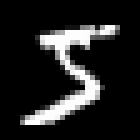

In [6]:
array_to_image(x_train[0], (28, 28, 1), 5)

Often, we need to do a little data preparation to get it ready for the learning model. Here, we flatten the inputs, and put input values in the range 0 - 1:

In [7]:
# run this cell first to create unflatted copy of the x_test data split for plotting later 
x_test_original = x_test.copy()

In [8]:
# preprocess and normalize the data 
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

60000 train samples
10000 test samples


In [9]:
# set random seed for reproducibility 
# see: https://stackoverflow.com/questions/21494489/what-does-numpy-random-seed0-do
np.random.seed(45)

And we examine the targets:

In [10]:
y_train.shape

(60000,)

We see that they are just 60,000 values. These are the integer representation of the picture. In this example, we wish to have 10 outputs representing, in a way, the probability of what the picture represents. 

To turn each number 0-9 into a 10-output vector for training, we use the `keras.utils.to_categorical` function to turn it into a so-called "one hot" representation:

In [11]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

We then can check to see if the picture above is labeled correctly:

In [12]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

Indeed, the first pattern is a 5. We can also visualize this vector like so:

In [13]:
array_to_image(y_train[0], (1, 10, 1), 20)

We can see the "one hot" representation showing that y_train[0][5] is 1.0, and all of the rest are zeros.

## 3. Model Definition

In [ ]:
# starting parameter set
# these parameters can be adjusted with different values. Feel free to experiment
batch_size = 128
num_classes = 10
epochs = 20
num_nodes = 64
optimizer = 'adam'
activation = 'relu'

In [26]:
def build_model_graph(input_shape=(784,)):
    model = Sequential()
    model.add(Dense(num_nodes, activation='relu', input_shape=(784,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

And call it to create the model:

In [27]:
model = build_model_graph()

We use the summary method to check the details:

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_5 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                2570      
Total params: 69,450
Trainable params: 69,450
Non-trainable params: 0
_________________________________________________________________


## 4. Comet Experiment

In order for comet.ml to log your experiment and results, you need to create an Experiment instance. To do this, you'll need two items:

* a Comet `api_key`
* a `project_name`

You can find your Comet api_key when you log in to https://comet.ml and click on your project. You should see a screen that looks similar to:

![comet_api_key](https://www.comet.ml/docs/img/register_3.png)

Click on the API key to copy the key to your clipboard. 

It is recommended that you put your COMET_API_KEY in a `.env` key in the current directory. You can do that using the following code. Put it in a cell, replace the `...` with your key, and then delete the cell. That way your key stays private.

```ipython
%%writefile .env

COMET_API_KEY=...
```

In [ ]:
experiment = Experiment(project_name="INSERT_YOUR_PROJECT_NAME")

If you get the error that ends with:

```python
ValueError: Comet.ml requires an API key. Please provide as the first argument to Experiment(api_key) or as an environment variable named COMET_API_KEY 
```

then that means that either you don't have an `.env` file in this directory, or the key is invalid.

Otherwise, you should see the message:

```
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/...
```

If you click the URL, then a new page will open up. But, even better, you can execute the following line to see the experiment in the current notebook:

In [20]:
experiment.display()

In [36]:
# Comet.ml has a method to log a hash of the dataset, so that we can see if it changes:
experiment.log_dataset_hash(x_train)

# 5. Training


In [37]:
params={'batch_size':batch_size,
        'epochs':epochs,
        'layer1_type':'Dense',
        'layer1_num_nodes':num_nodes,
        'layer1_activation':activation,
        'optimizer':optimizer
}

# log parameters in Comet.ml
experiment.log_multiple_params(params)

In [38]:
# Once you run this cell, you will be able to see the results live in the embedded Comet UI above 

# will log metrics with the prefix 'train_'
with experiment.train():
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test),
                        callbacks=[EarlyStopping(monitor='val_loss', min_delta=1e-4,patience=3, verbose=1, mode='auto')])

#will log metrics with the prefix 'test_'
with experiment.test():
    loss, accuracy = model.evaluate(x_test, y_test)
    metrics = {
        'loss':loss,
        'accuracy':accuracy
    }
    experiment.log_multiple_metrics(metrics)


Train on 60000 samples, validate on 10000 samples
Epoch 1/24
60000/60000 [==============================] - 2s 40us/step - loss: 0.0225 - acc: 0.9927 - val_loss: 0.0862 - val_acc: 0.9771
Epoch 2/24
60000/60000 [==============================] - 3s 44us/step - loss: 0.0219 - acc: 0.9925 - val_loss: 0.0942 - val_acc: 0.9765
Epoch 3/24
60000/60000 [==============================] - 2s 39us/step - loss: 0.0192 - acc: 0.9939 - val_loss: 0.0871 - val_acc: 0.9781
Epoch 4/24
60000/60000 [==============================] - 2s 39us/step - loss: 0.0153 - acc: 0.9949 - val_loss: 0.0969 - val_acc: 0.9778
Epoch 00004: early stopping
10000/10000 [==============================] - 0s 19us/step


# 6. Logging

In keras, Comet will automatically log:

* the model description
* the training loss
* the training accuracy
* the training validation loss
* the training validation accuracy
* the source code

To log other items manually, you can use any of the following:

* `experiment.log_html(HTML_STRING)`
* `experiment.html_log_url(URL_STRING)`
* `experiment.image(FILENAME)`
* `experiment.log_dataset_hash(DATASET)` (shown above)
* `experiment.log_other(KEY, VALUE)`
* `experiment.log_metric(NAME, VALUE)`  (shown above)
* `experiment.log_parameter(PARAMETER, VALUE)`  (shown above)
* `experiment.log_figure(NAME, FIGURE)`  (shown below)

For complete details, please see: 

https://www.comet.ml/docs/python-sdk/Experiment/#experiment

**Example: Logging a figure**
Let's plot a sample of our model's predictions and log it as a figure in Comet! 

In [39]:
import matplotlib.pyplot as plt

%matplotlib inline

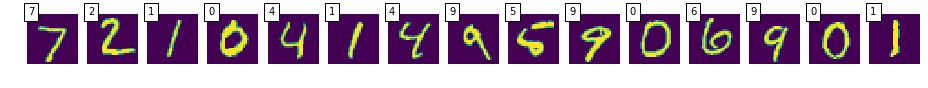

In [40]:
slice = 15
predicted = model.predict(x_test[:slice]).argmax(-1)

# remember our copy of x_test? This is where it comes into play again! 
# Since we flatted x_test during pre-processing, we need to preserve an unflattened version
plt.figure(figsize=(16,8))
for i in range(slice):
    plt.subplot(1, slice, i+1)
    plt.imshow(x_test_original[i], interpolation='nearest')
    plt.text(0, 0, predicted[i], color='black', 
             bbox=dict(facecolor='white', alpha=1))
    plt.axis('off')

# Check the 'Graphics' tab to see this logged figure 
experiment.log_figure('Model Sample Prediction', plt)

**Important Note:** Finally, we are ready to tell Comet that our experiment is complete. You don't need to do this is a script that ends. But in Jupyter, we need to indicate that the experiment is finished. We do that with the `experiment.end()` method:

In [41]:
experiment.end()

COMET INFO: Uploading stats to Comet before program termination (may take several seconds)
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/ceceshao1/jupyter-experiments/e4baa5e55cb2406e91354bdcca7a890c



# 7. Creating another experiment

If you would like to create another experiment, simply create a new Experiment(), and then the fit(), and finally, experiment.end()

You could also restart the kernel and clear the cell output, if you wanted a clear session. 

In **Section 3: Model Definition**, we defined a starting set of hyperparameters. Feel free to adjust those and log the resulting model results as another experiment and compare the difference! 

Comet also offers hyperparameter optimization: https://www.comet.ml/parameter-optimization


In [25]:
# try this second set of parameters 
batch_size = 64 # adjusted batch size from 128 to 64 
num_classes = 10
epochs = 24 # adjusted number of epochs from 20 to 24
num_nodes = 64
optimizer = 'adam'
activation = 'relu'

# Check out the Comet Hyperparameter tab for the new experiment and note the new epoch value of 24 

Continue by running **Section 4: Comet Experiment** onwards with these new parameters and see if there's a difference in performance! Don't forget to run `experiment.end()` at the end to mark the completion of your second experiment.

## Contact Comet
Have questions about this notebook or our new Jupyter support? Email us at mail@comet-ml.com or Slack us directly [here](https://join.slack.com/t/cometml/shared_invite/enQtMzM0OTMwNTQ0Mjc5LTM4ZDViODkyYTlmMTVlNWY0NzFjNGQ5Y2Q1Y2EwMjQ5MzQ4YmI2YjhmZTY3YmYxYTYxYTNkYzM4NjgxZmJjMDI)